# Jeu de données avec des catégories

Le jeu de données [Adult Data Set](https://archive.ics.uci.edu/ml/datasets/adult) ne contient presque que des catégories. Ce notebook explore différentes moyens de les traiter.

In [1]:
%matplotlib inline

In [2]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

## données

In [3]:
from papierstat.datasets import load_adult_dataset
train, test = load_adult_dataset(url="copy")
train.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,<=50K
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [4]:
label = '<=50K'
set(train[label])

{'<=50K', '>50K'}

In [5]:
set(test[label])

{'<=50K', '>50K'}

In [6]:
X_train = train.drop(label, axis=1)
y_train = train[label] == '>50K'
X_test = test.drop(label, axis=1)
y_test = test[label] == '>50K'

In [7]:
train.dtypes

age                int64
workclass         object
fnlwgt             int64
education         object
education_num      int64
marital_status    object
occupation        object
relationship      object
race              object
sex               object
capital_gain       int64
capital_loss       int64
hours_per_week     int64
native_country    object
<=50K             object
dtype: object

La variable *fnlwgt* représente une forme de pondération : le nombre d'individus que chaque observation représente. Elle ne doit pas servir à la prédiction, comme pondération qu'on ignorera.

In [8]:
X_train = X_train.drop(['fnlwgt'], axis=1).copy()
X_test = X_test.drop(['fnlwgt'], axis=1).copy()

## catégories

On garde la liste des variables catégorielles.

In [9]:
cat_col = list(_ for _ in X_train.select_dtypes("object").columns)
cat_col

['workclass',
 'education',
 'marital_status',
 'occupation',
 'relationship',
 'race',
 'sex',
 'native_country']

La fonction [get_dummies](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html) est pratique mais problématique si les modalités de la base d'apprentissage et la base de test sont différentes, ce qui est fréquemment le cas pour les catégories peu fréquentes. On veut utiliser [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) et [LabelEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html) mais ce n'est pas très pratique.

In [10]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
pipe = make_pipeline(LabelEncoder(), OneHotEncoder())
try:
    pipe.fit(X_train[cat_col[0]], y_train)
except Exception as e:
    print(e)

fit_transform() takes 2 positional arguments but 3 were given


On utilise [OneHotEncoder](http://contrib.scikit-learn.org/categorical-encoding/).

In [11]:
from category_encoders import OneHotEncoder
ce = OneHotEncoder(cols=cat_col, impute_missing=False, drop_invariant=False, handle_unknown='error')
X_train_cat = ce.fit_transform(X_train)
X_train_cat.head()

,workclass_0,workclass_1,workclass_2,workclass_3,workclass_4,workclass_5,workclass_6,workclass_7,workclass_8,education_0,...,native_country_37,native_country_38,native_country_39,native_country_40,native_country_41,age,education_num,capital_gain,capital_loss,hours_per_week
0,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,39,13,2174,0,40
1,0,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,50,13,0,0,13
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,38,9,0,0,40
3,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,53,7,0,0,40
4,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,28,13,0,0,40


C'est assez compliqué à lire. Le code suivant ne produit pas toujours un résultat correct si ``drop_invariant=False``.

In [12]:
cols = []
for co in X_train.columns:
    if co in cat_col:
        ind = cat_col.index(co)
        mapping = ce.category_mapping[ind]['mapping']
        for m in mapping:
            cols.append(co + "/" + m[0].strip())
X_train_cat.columns = cols + list(X_train_cat.columns)[len(cols):]
X_train_cat.head()

,workclass/State-gov,workclass/Self-emp-not-inc,workclass/Private,workclass/Federal-gov,workclass/Local-gov,workclass/?,workclass/Self-emp-inc,workclass/Without-pay,workclass/Never-worked,education/Bachelors,...,native_country/Vietnam,native_country/Hong,native_country/Ireland,native_country/Hungary,native_country/Holand-Netherlands,age,education_num,capital_gain,capital_loss,hours_per_week
0,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,39,13,2174,0,40
1,0,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,50,13,0,0,13
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,38,9,0,0,40
3,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,53,7,0,0,40
4,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,28,13,0,0,40


## premier jet

On construit un pipeline.

In [13]:
from sklearn.linear_model import LogisticRegression
pipe = make_pipeline(
            OneHotEncoder(cols=cat_col, impute_missing=False, drop_invariant=False, handle_unknown='error'), 
            LogisticRegression())
pipe.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('onehotencoder', OneHotEncoder(cols=['workclass', 'education', 'marital_status', 'occupation', 'relationship', 'race', 'sex', 'native_country'],
       drop_invariant=False, handle_unknown='error', impute_missing=False,
       return_df=True, verbose=0)), ('logisticregression', LogisticRegre...ty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

In [14]:
pipe.score(X_test, y_test)

0.8516061666973773

On essaye avec une [RandomForest](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html).

In [15]:
from sklearn.ensemble import RandomForestClassifier
pipe2 = make_pipeline(ce, RandomForestClassifier(n_estimators=100))
pipe2.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('onehotencoder', OneHotEncoder(cols=['workclass', 'education', 'marital_status', 'occupation', 'relationship', 'race', 'sex', 'native_country'],
       drop_invariant=False, handle_unknown='error', impute_missing=False,
       return_df=True, verbose=0)), ('randomforestclassifier', RandomFor...n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])

In [16]:
pipe2.score(X_test, y_test)

0.8438056630428107

In [17]:
pipe2.steps[-1][-1].feature_importances_[:5]

array([0.00524581, 0.00929932, 0.01159703, 0.00559554, 0.00632061])

On regarde l'importance des features.

In [18]:
import pandas
df = pandas.DataFrame(dict(name=X_train_cat.columns, 
                           importance=pipe2.steps[-1][-1].feature_importances_))
df = df.sort_values("importance", ascending=False).reset_index(drop=True)
df = df.set_index('name')
df.head()

,importance
name,
age,0.224329
hours_per_week,0.114420
capital_gain,0.106778
education_num,0.061716
marital_status/Married-civ-spouse,0.060291


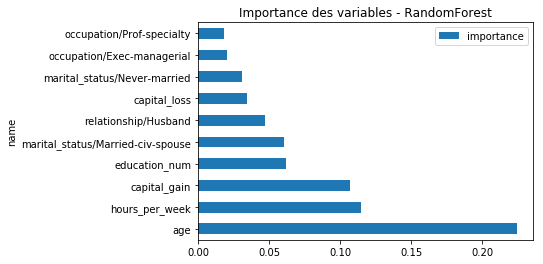

In [19]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
df[:10].plot.barh(ax=ax)
ax.set_title('Importance des variables - RandomForest');

On compare avec [XGBoost](http://xgboost.readthedocs.io/en/latest/model.html).

In [20]:
from xgboost import XGBClassifier
pipe3 = make_pipeline(ce, XGBClassifier())
pipe3.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('onehotencoder', OneHotEncoder(cols=['workclass', 'education', 'marital_status', 'occupation', 'relationship', 'race', 'sex', 'native_country'],
       drop_invariant=False, handle_unknown='error', impute_missing=False,
       return_df=True, verbose=0)), ('xgbclassifier', XGBClassifier(base...
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1))])

In [21]:
pipe3.score(X_test, y_test)

c:\Python364_x64\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.869172655242307

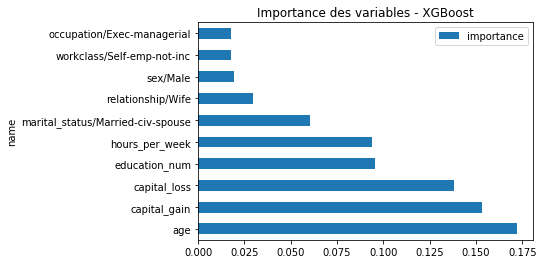

In [22]:
df = pandas.DataFrame(dict(name=X_train_cat.columns, 
                           importance=pipe3.steps[-1][-1].feature_importances_))
df = df.sort_values("importance", ascending=False).reset_index(drop=True)
df = df.set_index('name')
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
df[:10].plot.barh(ax=ax)
ax.set_title('Importance des variables - XGBoost');

On retrouve presque les mêmes variables mais pas dans le même ordre. On essaye un dernier module [catboost](https://tech.yandex.com/catboost/).

In [23]:
from catboost import CatBoostClassifier
pipe4 = make_pipeline(ce, CatBoostClassifier(iterations=100, verbose=False))
pipe4.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('onehotencoder', OneHotEncoder(cols=['workclass', 'education', 'marital_status', 'occupation', 'relationship', 'race', 'sex', 'native_country'],
       drop_invariant=False, handle_unknown='error', impute_missing=False,
       return_df=True, verbose=0)), ('catboostclassifier', <catboost.core.CatBoostClassifier object at 0x000001FAAA0525C0>)])

In [24]:
pipe4.score(X_test, y_test)

0.8624777347828757

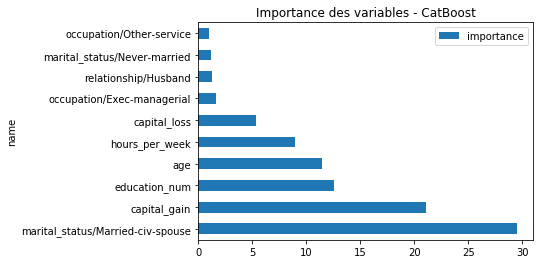

In [25]:
df = pandas.DataFrame(dict(name=X_train_cat.columns, 
                           importance=pipe4.steps[-1][-1].feature_importances_))
df = df.sort_values("importance", ascending=False).reset_index(drop=True)
df = df.set_index('name')
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
df[:10].plot.barh(ax=ax)
ax.set_title('Importance des variables - CatBoost');

## Courbe ROC

In [26]:
from sklearn.metrics import roc_curve
fpr2, tpr2, th2 = roc_curve(y_test, pipe2.predict_proba(X_test)[:, 1], 
                            pos_label=pipe2.steps[-1][-1].classes_[1], drop_intermediate=False)
fpr3, tpr3, th3 = roc_curve(y_test, pipe3.predict_proba(X_test)[:, 1], 
                            pos_label=pipe3.steps[-1][-1].classes_[1], drop_intermediate=False)
fpr4, tpr4, th4 = roc_curve(y_test, pipe4.predict_proba(X_test)[:, 1], 
                            pos_label=pipe4.steps[-1][-1].classes_[1], drop_intermediate=False)

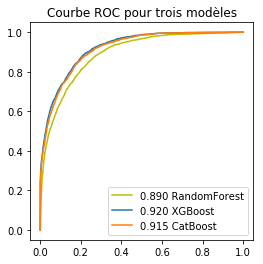

In [27]:
from sklearn.metrics import auc
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
ax.plot(fpr2, tpr2, label='%1.3f RandomForest' % auc(fpr2, tpr2), color='y')
ax.plot(fpr3, tpr3, label='%1.3f XGBoost' % auc(fpr3, tpr3))
ax.plot(fpr4, tpr4, label='%1.3f CatBoost' % auc(fpr4, tpr4))
ax.legend()
ax.set_title('Courbe ROC pour trois modèles');

## GridSearch

On cherche à optimiser les hyperparamètres sur la base d'apprentissage. On la mélange pour éviter les effets imprévisibles dûs à l'ordre de saisie des données.

In [28]:
from sklearn.model_selection import cross_val_score
cross_val_score(pipe2, X_train, y_train, cv=5)

array([0.8502994 , 0.84336609, 0.84121622, 0.85181204, 0.84889435])

In [29]:
from pandas_streaming.df import dataframe_shuffle
from numpy.random import permutation
index = permutation(X_train.index)
X_train_shuffled = X_train.iloc[index, :]
y_train_shuffled = y_train[index]
cross_val_score(pipe2, X_train_shuffled, y_train_shuffled, cv=5)

array([0.84262245, 0.85135135, 0.84935504, 0.84643735, 0.84812654])

L'ordre de la base n'a pas d'incidence.

In [30]:
from sklearn.model_selection import GridSearchCV
param_grid = {'randomforestclassifier__n_estimators':[10, 20, 50],
              'randomforestclassifier__min_samples_leaf': [2, 10]}
cvgrid = GridSearchCV(estimator=pipe2, param_grid=param_grid, verbose=2)
cvgrid.fit(X_train, y_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV] randomforestclassifier__min_samples_leaf=2, randomforestclassifier__n_estimators=10 
[CV]  randomforestclassifier__min_samples_leaf=2, randomforestclassifier__n_estimators=10, total=   3.5s
[CV] randomforestclassifier__min_samples_leaf=2, randomforestclassifier__n_estimators=10 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.9s remaining:    0.0s


[CV]  randomforestclassifier__min_samples_leaf=2, randomforestclassifier__n_estimators=10, total=   3.6s
[CV] randomforestclassifier__min_samples_leaf=2, randomforestclassifier__n_estimators=10 
[CV]  randomforestclassifier__min_samples_leaf=2, randomforestclassifier__n_estimators=10, total=   3.5s
[CV] randomforestclassifier__min_samples_leaf=2, randomforestclassifier__n_estimators=20 
[CV]  randomforestclassifier__min_samples_leaf=2, randomforestclassifier__n_estimators=20, total=   4.1s
[CV] randomforestclassifier__min_samples_leaf=2, randomforestclassifier__n_estimators=20 
[CV]  randomforestclassifier__min_samples_leaf=2, randomforestclassifier__n_estimators=20, total=   3.9s
[CV] randomforestclassifier__min_samples_leaf=2, randomforestclassifier__n_estimators=20 
[CV]  randomforestclassifier__min_samples_leaf=2, randomforestclassifier__n_estimators=20, total=   4.0s
[CV] randomforestclassifier__min_samples_leaf=2, randomforestclassifier__n_estimators=50 
[CV]  randomforestclassif

[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:  1.8min finished


GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('onehotencoder', OneHotEncoder(cols=['workclass', 'education', 'marital_status', 'occupation', 'relationship', 'race', 'sex', 'native_country'],
       drop_invariant=False, handle_unknown='error', impute_missing=False,
       return_df=True, verbose=0)), ('randomforestclassifier', RandomFor...n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'randomforestclassifier__n_estimators': [10, 20, 50], 'randomforestclassifier__min_samples_leaf': [2, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=2)

In [31]:
import pandas
df = pandas.DataFrame(cvgrid.cv_results_['params'])
df['mean_fit_time'] = cvgrid.cv_results_['mean_fit_time']
df['mean_test_score'] = cvgrid.cv_results_['mean_test_score']
df.sort_values('mean_test_score')

,randomforestclassifier__min_samples_leaf,randomforestclassifier__n_estimators,mean_fit_time,mean_test_score
3,10,10,2.755744,0.855717
4,10,20,3.061685,0.857836
5,10,50,3.970899,0.857928
0,2,10,2.662768,0.861675
1,2,20,3.075118,0.863426
2,2,50,4.610395,0.863548


Il faudrait continuer à explorer les hyperparamètres et confirmer sur la base de test. A priori, cela marche mieux avec plus d'arbres.

## Features polynômiales

In [32]:
from sklearn.preprocessing import PolynomialFeatures
pipe5 = make_pipeline(ce, PolynomialFeatures(), RandomForestClassifier())
pipe5.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('onehotencoder', OneHotEncoder(cols=['workclass', 'education', 'marital_status', 'occupation', 'relationship', 'race', 'sex', 'native_country'],
       drop_invariant=False, handle_unknown='error', impute_missing=False,
       return_df=True, verbose=0)), ('polynomialfeatures', PolynomialFea...n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])

In [33]:
pipe5.score(X_test, y_test)

0.8415330753639212

Ca n'améliore pas.

## Interprétation

On souhaite en savoir plus sur les variables.

In [34]:
conc = pandas.concat([X_train_cat, y_train], axis=1)
conc.head()

,workclass/State-gov,workclass/Self-emp-not-inc,workclass/Private,workclass/Federal-gov,workclass/Local-gov,workclass/?,workclass/Self-emp-inc,workclass/Without-pay,workclass/Never-worked,education/Bachelors,...,native_country/Hong,native_country/Ireland,native_country/Hungary,native_country/Holand-Netherlands,age,education_num,capital_gain,capital_loss,hours_per_week,<=50K
0,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,39,13,2174,0,40,False
1,0,1,0,0,0,0,0,0,0,1,...,0,0,0,0,50,13,0,0,13,False
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,38,9,0,0,40,False
3,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,53,7,0,0,40,False
4,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,28,13,0,0,40,False


In [35]:
corr = conc.corr()

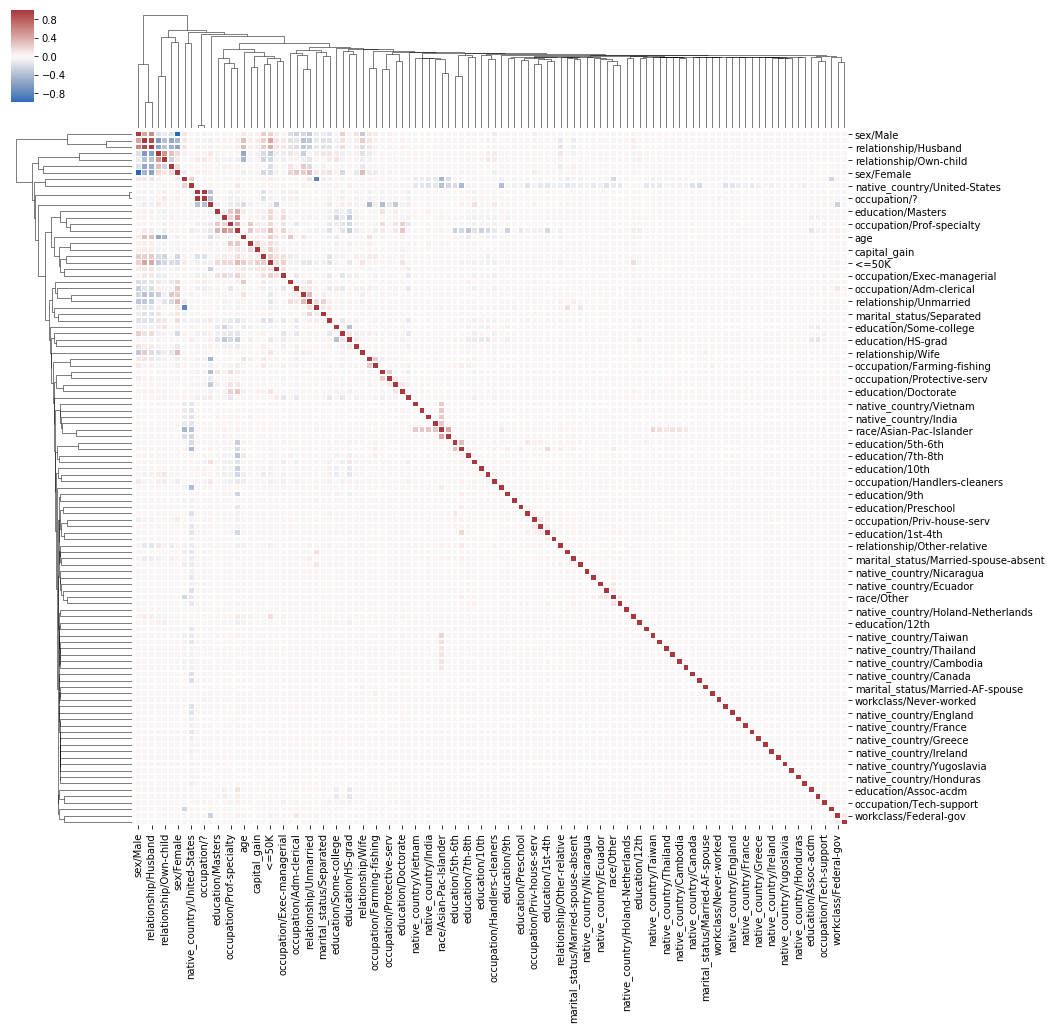

In [36]:
from seaborn import clustermap

clustermap(corr, center=0, cmap="vlag", linewidths=.75, figsize=(15, 15));

Ce n'est pas facile à voir. 

## ACM

In [37]:
from sklearn.preprocessing import StandardScaler
import pandas
rows_cat = pandas.DataFrame(StandardScaler().fit_transform(X_train_cat))
rows_cat.columns = X_train_cat.columns
rows_cat = rows_cat.T
rows_cat.head(n=2)

,0,1,2,3,4,5,6,7,8,9,...,32551,32552,32553,32554,32555,32556,32557,32558,32559,32560
workclass/State-gov,4.907700,-0.203761,-0.203761,-0.203761,-0.203761,-0.203761,-0.203761,-0.203761,-0.203761,-0.203761,...,-0.203761,-0.203761,-0.203761,-0.203761,-0.203761,-0.203761,-0.203761,-0.203761,-0.203761,-0.203761
workclass/Self-emp-not-inc,-0.290936,3.437186,-0.290936,-0.290936,-0.290936,-0.290936,-0.290936,3.437186,-0.290936,-0.290936,...,-0.290936,-0.290936,-0.290936,-0.290936,-0.290936,-0.290936,-0.290936,-0.290936,-0.290936,-0.290936


In [38]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
pca = PCA(n_components=2)
pca.fit(rows_cat)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [39]:
import pandas
tr = pandas.DataFrame(pca.transform(rows_cat))
tr.columns = ['axe1', 'axe2']
tr.index = rows_cat.index
tr.sort_values('axe1').head(n=2)

,axe1,axe2
sex/Female,-129.498913,60.845568
marital_status/Never-married,-106.132225,-11.378134


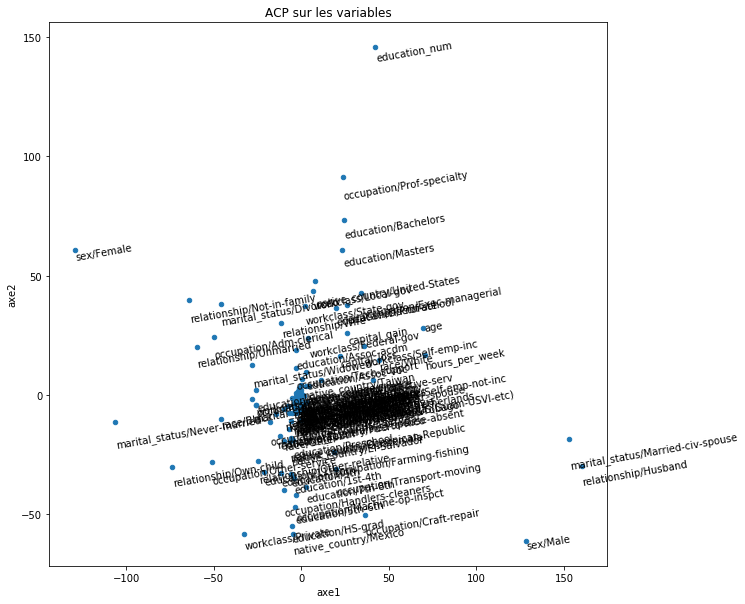

In [40]:
ax = tr.plot(x='axe1', y='axe2', kind='scatter', figsize=(10, 10))
for t, (x, y) in tr.iterrows():
    ax.text(x, y, t, fontsize=10, rotation=10)
ax.set_title("ACP sur les variables");

On voit quelques variables à supprimer car très corrélées. Un petit peu plus de temps, quelques zoom et on pourrait supprimer quelques variables.

## Analyse d'erreur

On recherche les erreurs les plus flagrantes, celles dont le score est élevé.

In [41]:
pred = pipe.predict(X_test)
proba = pipe.predict_proba(X_test)
pred2 = pipe2.predict(X_test)
proba2 = pipe2.predict_proba(X_test)
pred3 = pipe3.predict(X_test)
proba3 = pipe3.predict_proba(X_test)
pred4 = pipe4.predict(X_test)
proba4 = pipe4.predict_proba(X_test)

c:\Python364_x64\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [42]:
data = pandas.concat([
            pandas.DataFrame(y_test.astype(float).as_matrix(), columns=['y_test']),
            pandas.DataFrame(pred, columns=['pred1']),
            pandas.DataFrame(proba[:,1], columns=['P1(>=50K)']),
            pandas.DataFrame(pred2, columns=['pred2']),
            pandas.DataFrame(proba2[:,1], columns=['P2(>=50K)']),
            pandas.DataFrame(pred3, columns=['pred3']),
            pandas.DataFrame(proba3[:,1], columns=['P3(>=50K)']),
            pandas.DataFrame(pred4, columns=['pred4']),
            pandas.DataFrame(proba4[:,1], columns=['P4(>=50K)']),
            X_test,
            ], axis=1)
data.head()

,y_test,pred1,P1(>=50K),pred2,P2(>=50K),pred3,P3(>=50K),pred4,P4(>=50K),age,...,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country
0,0.0,False,0.002997,False,0.000000,False,0.007642,0.0,0.007992,25,...,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States
1,0.0,False,0.138880,False,0.037857,False,0.203497,0.0,0.277878,38,...,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States
2,1.0,False,0.364649,True,0.569333,False,0.277167,0.0,0.295065,28,...,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States
3,1.0,True,0.754975,True,0.920000,True,0.984138,1.0,0.959132,44,...,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States
4,0.0,False,0.001904,False,0.000000,False,0.002210,0.0,0.006588,18,...,10,Never-married,?,Own-child,White,Female,0,0,30,United-States


In [43]:
data[data.y_test != data.pred4].sort_values('P4(>=50K)', ascending=False).head().T

,3605,4143,2926,786,1418
y_test,0,0,0,0,0
pred1,True,True,True,True,True
P1(>=50K),0.999997,0.927754,0.779498,0.844606,0.97892
pred2,True,True,True,True,True
P2(>=50K),0.76,0.85,0.75,0.81,0.96
pred3,True,True,True,True,True
P3(>=50K),0.972606,0.881992,0.900088,0.838751,0.833428
pred4,1,1,1,1,1
P4(>=50K),0.97496,0.939005,0.926902,0.926081,0.900521
age,36,64,65,67,55


Tous les modèles font l'erreur sur ces cinq exemples. Le modèle a toutes les raisons de décider que les personnes gagnent plus de 50k par an, beaucoup d'études, plutôt âge ou travaillant beaucoup.

In [44]:
wrong_study = data[data.y_test != data.pred4].sort_values('P4(>=50K)', ascending=True).head(n=3).T
wrong_study

,5953,10408,3059
y_test,1,1,1
pred1,False,False,False
P1(>=50K),0.00231258,0.00219724,0.0280105
pred2,False,False,False
P2(>=50K),0,0,0
pred3,False,False,False
P3(>=50K),0.00299048,0.00288558,0.00561586
pred4,0,0,0
P4(>=50K),0.00586112,0.00608453,0.00801143
age,20,22,22


Ceux-ci sont probablement étudiants et déjà aisés. Il faudrait avoir quelques informations sur les parents pour confirmer. On recherche les plus proches voisins dans la base pour voir ce que le modèle répond. Il faut néanmoins appliquer cela sur la base une fois les catégories transformées.

In [45]:
from sklearn.neighbors import NearestNeighbors
knn = NearestNeighbors()
knn.fit(X_train_cat)

NearestNeighbors(algorithm='auto', leaf_size=30, metric='minkowski',
         metric_params=None, n_jobs=1, n_neighbors=5, p=2, radius=1.0)

In [46]:
X_test_cat = pipe2.steps[0][-1].transform(X_test)
X_test_cat.columns = X_train_cat.columns

In [47]:
wrong = data[data.y_test != data.pred4].sort_values('P4(>=50K)', ascending=True).head()
wrong.head(n=2)

,y_test,pred1,P1(>=50K),pred2,P2(>=50K),pred3,P3(>=50K),pred4,P4(>=50K),age,...,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country
5953,1.0,False,0.002313,False,0.0,False,0.002990,0.0,0.005861,20,...,8,Never-married,Other-service,Own-child,Black,Male,0,0,35,United-States
10408,1.0,False,0.002197,False,0.0,False,0.002886,0.0,0.006085,22,...,10,Never-married,?,Own-child,White,Male,0,0,15,?


In [48]:
wrong_cat = X_test_cat.iloc[wrong.index, :]
wrong_cat.head()

,workclass/State-gov,workclass/Self-emp-not-inc,workclass/Private,workclass/Federal-gov,workclass/Local-gov,workclass/?,workclass/Self-emp-inc,workclass/Without-pay,workclass/Never-worked,education/Bachelors,...,native_country/Vietnam,native_country/Hong,native_country/Ireland,native_country/Hungary,native_country/Holand-Netherlands,age,education_num,capital_gain,capital_loss,hours_per_week
5953,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,20,8,0,0,35
10408,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,22,10,0,0,15
3059,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,22,10,0,0,25
11821,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,24,7,0,0,40
14757,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,25,10,0,1564,37


In [49]:
dist, index = knn.kneighbors(wrong_cat)
dist

array([[ 1.41421356,  1.41421356,  2.23606798,  2.23606798,  2.23606798],
       [ 2.        ,  2.        ,  2.23606798,  2.44948974,  2.44948974],
       [ 1.        ,  1.41421356,  1.41421356,  1.73205081,  1.73205081],
       [ 1.41421356,  1.73205081,  1.73205081,  1.73205081,  2.        ],
       [ 5.91607978,  7.28010989,  8.30662386, 11.18033989, 11.26942767]])

In [50]:
index

array([[24878, 30060, 27902,  8008, 23771],
       [18056, 18362,  8757, 13177,   314],
       [  920, 31176,  5206,  7415, 15308],
       [17303, 18592,  2019, 20325,  7542],
       [15608, 13506, 25150,    93, 11384]], dtype=int64)

In [51]:
train_nn = pandas.concat([X_train, y_train], axis=1).iloc[[24878, 18056, 920], :].T
train_nn.columns = ['TR-' + str(_) for _ in train_nn.columns]
train_nn

,TR-24878,TR-18056,TR-920
age,20,21,23
workclass,Private,?,Private
education,12th,Some-college,Some-college
education_num,8,10,10
marital_status,Never-married,Never-married,Never-married
occupation,Other-service,?,Sales
relationship,Own-child,Own-child,Not-in-family
race,White,White,White
sex,Male,Male,Male
capital_gain,0,0,0


Il faut ocmparer la première colonne avec la quatrième, la seconde avec la ciinquième et la troisème avec la sixième. Ces exemples sont voisins. On voit que les exemples sont très proches. Il n'y a qu'une seule valeur qui change à chaque fois et il est difficile d'expliquer les erreurs.

In [52]:
pandas.concat([train_nn, wrong_study], axis=1)

,TR-24878,TR-18056,TR-920,5953,10408,3059
<=50K,False,False,False,NaN,NaN,NaN
P1(>=50K),NaN,NaN,NaN,0.00231258,0.00219724,0.0280105
P2(>=50K),NaN,NaN,NaN,0,0,0
P3(>=50K),NaN,NaN,NaN,0.00299048,0.00288558,0.00561586
P4(>=50K),NaN,NaN,NaN,0.00586112,0.00608453,0.00801143
age,20,21,23,20,22,22
capital_gain,0,0,0,0,0,0
capital_loss,0,0,0,0,0,0
education,12th,Some-college,Some-college,12th,Some-college,Some-college
education_num,8,10,10,8,10,10
